In [1]:
import tensorflow as tf
import splitfolders

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [ ]:
# splitfolders.ratio('data', output="train_test_val", seed=1337, ratio=(.8, 0.1,0.1)) 

In [2]:
PATH = 'train_test_val'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

# Variables for pre-processing and training.
batch_size = 32
epochs = 25
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_DEPTH = 3

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

In [3]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)


train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           batch_size=batch_size,)

val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                              batch_size=batch_size)

test_data_gen = test_image_generator.flow_from_directory(PATH,
                                                         target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                         batch_size=batch_size,
                                                         classes=["test"],
                                                         class_mode='sparse',
                                                         shuffle=False)

Found 12804 images belonging to 10 classes.
Found 1597 images belonging to 10 classes.
Found 1610 images belonging to 1 classes.


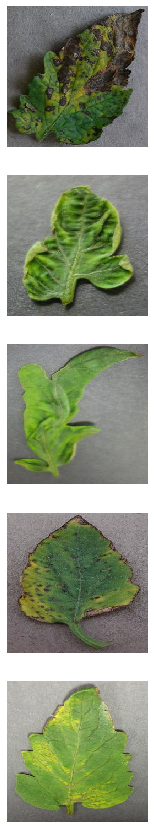

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [5]:
train_image_generator = ImageDataGenerator(rotation_range=25,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest',
                                           rescale=1./255
)

Found 12804 images belonging to 10 classes.


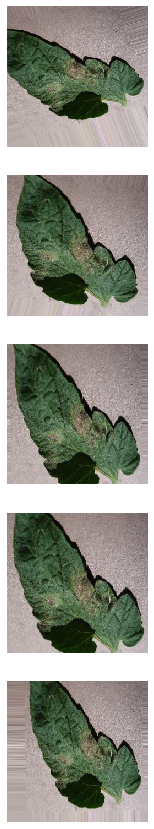

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 82, 82, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
import math

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(total_train)
val_steps = compute_steps_per_epoch(total_val)

In [ ]:
history = model.fit(train_data_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=val_steps)